<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/intro/2021/intro_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Autoencoders

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
# mpl.rcParams["figure.dpi"] = 300

mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [3]:
import numpy as np
np.random.seed(42)

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.4.1'

In [5]:
tf.random.set_seed(42)

In [6]:
!nvidia-smi

Wed Apr 14 12:06:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

In [8]:
from lrcurve import KerasLearningCurve

# Step 1: Load and prepare data

In [9]:
# screenshots from the application that is supposed to be mainly correct
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/app-testing/golden-master.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7589k  100 7589k    0     0  14.7M      0 --:--:-- --:--:-- --:--:-- 14.7M


In [10]:
!unzip -jqo golden-master.zip -d train

In [11]:
# !ls train

In [12]:
# screenshots from the new version containing regressions
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/app-testing/regression.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  830k  100  830k    0     0  3390k      0 --:--:-- --:--:-- --:--:-- 3390k


In [13]:
!unzip -jqo regression.zip -d test

In [14]:
# !ls -l test

In [15]:
# for a symmetric form of the autoencoder, a power of two for the resolution is easiest
x_res, y_res = (256, 256)

In [16]:
import os
import numpy as np
from skimage import data, io, filters
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.color import rgb2gray

def read_images_from_dir(data_dir, dims=(356, 384), type = ".png"):
  x_dim, y_dim = dims
  images = []
  file_names = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(type)]
  for f in file_names:
    image = io.imread(f)
    # some images from regressed application often have an additional line break
    # we take the easy route and simply clip to have the same size for all images
    image = image[:x_dim, :y_dim]
    image = rgb2gray(image)
    image = resize(image, (x_res, y_res))
    images.append(image)

  images = np.array(images)

  return images

In [17]:
train = read_images_from_dir("train")
train.shape, train.dtype

((603, 256, 256), dtype('float64'))

In [18]:
test = read_images_from_dir("test")
test.shape, test.dtype

((51, 256, 256), dtype('float64'))

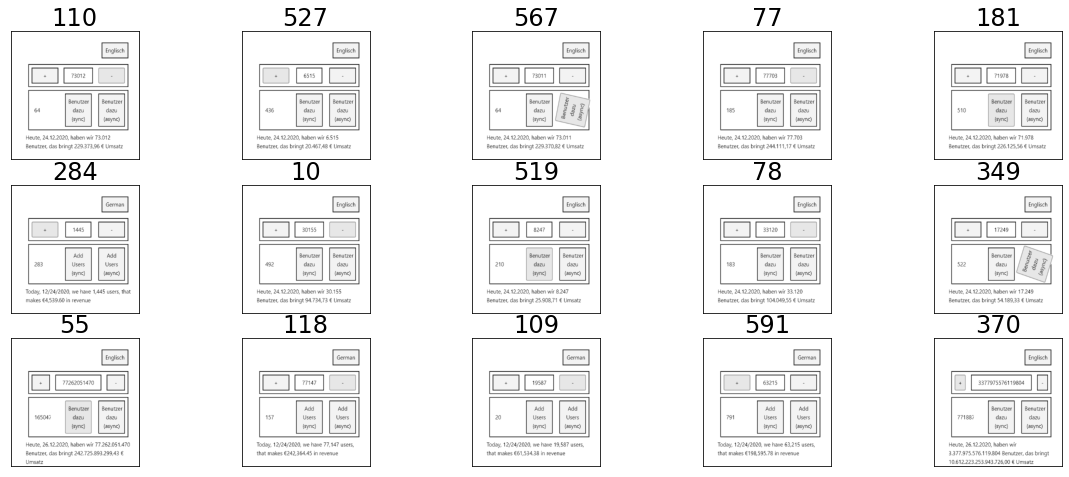

In [19]:
def plot_samples(x, n_samples=15):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index], cmap="gray")
      ax.set_title("{}".format(index))
        
plot_samples(train)

# Step 2: Train a Deep CNN Autoencoder

* Encoder uses convolutional layers
* Decoder does deconvoluation
* Bottleneck minimally uses 8 neurons, but these can be easily configured. Less than 8 will probably not train
* l2 to compress latent space a bit
* could use l1 to increase sparsity of embedding when having dim > 2, to have an additional restriction (often gives better results)
*  rounded accuracy counts how many pixels match approximately

In [20]:
from tensorflow import keras

# rounded to b/w, how many pixels fit approximately?
# taken from: https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb#scrollTo=vTfcqDgW-Kff
@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [21]:
def rounded_accuracy_for_single_image(true, predicted):
  return tf.reduce_mean(rounded_accuracy(true, predicted.astype('float64'))).numpy()    

In [22]:
# going much lower will not work
encoding_dim = 8
# seems to work a bit nicer, but reducing for viz gives worse results
# encoding_dim = 16

In [23]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape, Flatten
from tensorflow.keras.models import Model, Sequential

from tensorflow import keras

kernel_size = 4
stride = 2

conv_encoder = Sequential([
    Input(shape=(x_res, y_res)),
    Reshape((x_res, y_res, 1)),
    Conv2D(64, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(16, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    # MaxPooling2D(pool_size=2),
    # Conv2D(8, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    # MaxPooling2D(pool_size=2),
    # Conv2D(4, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    # MaxPooling2D(pool_size=2),
    Conv2D(1, name='collection_image', kernel_size=kernel_size, strides=1, padding="same"),
    Flatten(),
    # this creates our latent representation
    Dense(encoding_dim, 
          name='latent_representation',
          # activation="relu", 
          activation="linear", 
          # activity_regularizer=keras.regularizers.l2(1e-4),
          # activity_regularizer=keras.regularizers.l1(5e-4)),
          # activity_regularizer=keras.regularizers.l1_l2(l1=1e-4, l2=1e-4)
         ),

])
conv_decoder = Sequential([
    # this accepts the latent representation
    Input(shape=(encoding_dim)),
    # Reshape((4, 4, 1)),
    Reshape((1, 1, encoding_dim)),
    Conv2DTranspose(8, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    UpSampling2D(size=2),
    Conv2DTranspose(16, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    UpSampling2D(size=2),
    Conv2DTranspose(32, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    UpSampling2D(size=2),
    Conv2DTranspose(64, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    UpSampling2D(size=2),
    Conv2DTranspose(1, kernel_size=kernel_size, strides=1, padding="same", activation="sigmoid"),
    Reshape((x_res, y_res))
])
conv_ae = Sequential([conv_encoder, conv_decoder])

conv_ae.compile(
    optimizer='adam',
    # optimizer='sgd', # will not train
    loss="binary_crossentropy", 
    # loss="mse", # will not train either
    metrics=[rounded_accuracy])

# conv_encoder.summary()
# conv_decoder.summary()

In [24]:
from tensorflow.keras.utils import plot_model
# plot_model(conv_encoder, to_file="encoder.png", show_shapes=True, show_layer_names=False, dpi=300)
# plot_model(conv_encoder, show_shapes=True, show_layer_names=False)

In [25]:
# plot_model(conv_decoder, to_file="decoder.png", show_shapes=True, show_layer_names=False, dpi=300)
# plot_model(conv_decoder, show_shapes=True, show_layer_names=False)

In [26]:
%%time

# bring this down if training does not work any more
# can be higher when diemension of hidden representation is higher
BATCH_SIZE = 4 # for 16
# BATCH_SIZE = 2 # for 8
# typically is more than enough
EPOCHS = 100
# EPOCHS = 50

history = conv_ae.fit(train, train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(test, test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)

CPU times: user 1min 42s, sys: 8.12 s, total: 1min 50s
Wall time: 2min 19s


In [27]:
train_loss, train_accuracy = conv_ae.evaluate(train, train, batch_size=BATCH_SIZE, verbose=0)
train_accuracy

0.991788923740387

In [28]:
test_loss, test_accuracy = conv_ae.evaluate(test, test, batch_size=BATCH_SIZE, verbose=0)
test_accuracy

0.9783346056938171

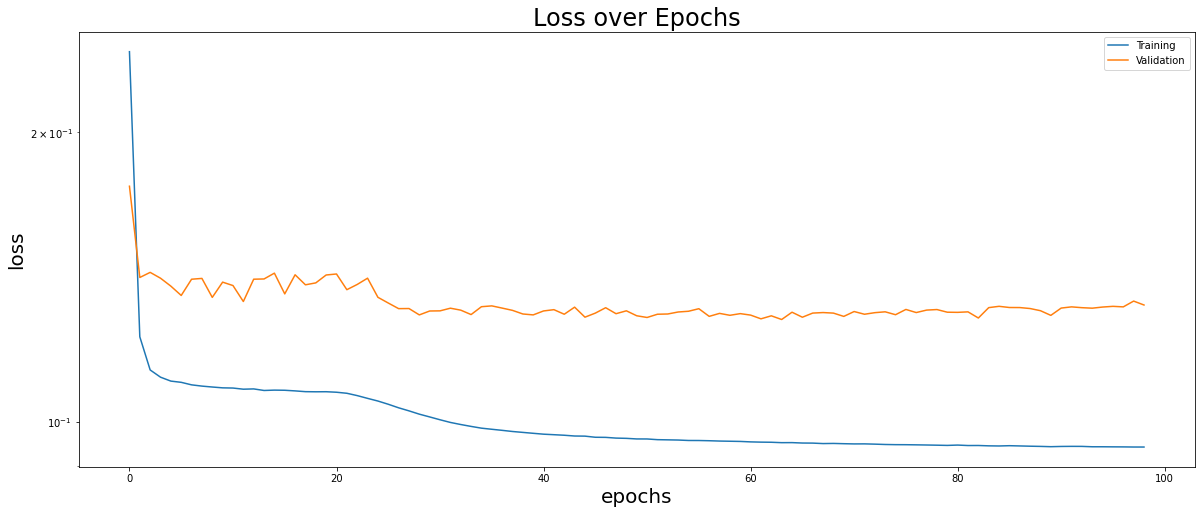

In [29]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Validation']);

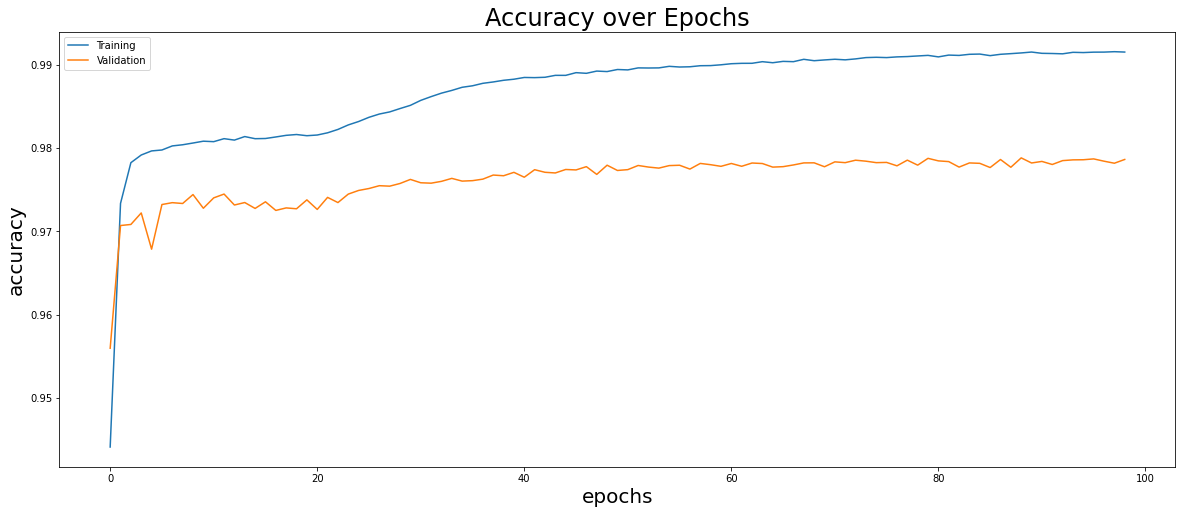

In [30]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over Epochs')

plt.plot(history.history['rounded_accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_rounded_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Validation']);

# Step 3: Validate Results

In [31]:
train_pred = conv_ae.predict(train)
# plot_samples(train_pred)

### True

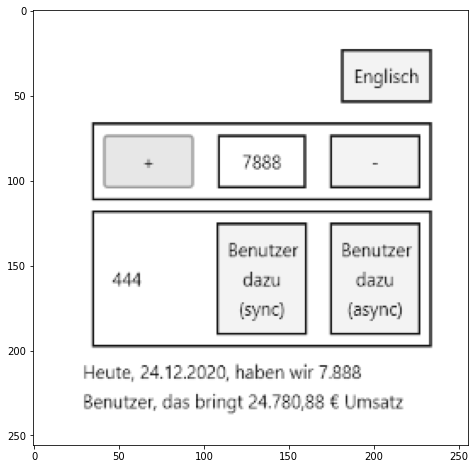

In [32]:
index = 50
plt.imshow(train[index], cmap='gray');
# io.imsave('train_true.png', train[index])

### Prediction

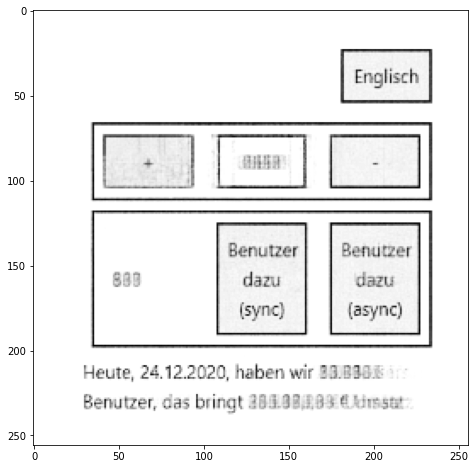

In [33]:
plt.imshow(train_pred[index], cmap='gray');
# io.imsave('train_pred.png', train_pred[index])

In [34]:
rounded_accuracy_for_single_image(train[50], train_pred[50])

0.99131775

In [35]:
test_pred = conv_ae.predict(test)
# plot_samples(test_pred)

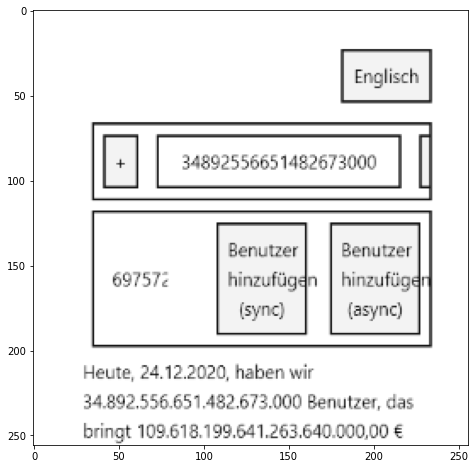

In [36]:
index = 21
# index = 24
plt.imshow(test[index], cmap='gray');
# io.imsave('test_true.png', test[index])

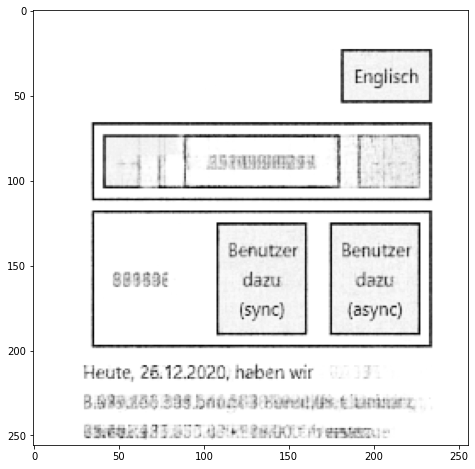

In [37]:
plt.imshow(test_pred[index], cmap='gray');
# io.imsave('test_pred.png', test_pred[index])

In [38]:
rounded_accuracy_for_single_image(test[0], test_pred[0])

0.9752197

## Comparing samples from Training Set

In [39]:
def compare_samples(x, x_pred, n_samples=5, display_accuracy=True):
  n_samples = min(n_samples, len(x))
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(2, n_samples, i + 1, xticks=[], yticks=[])
      ax.set_title("{}".format(index))
      ax.imshow(x[index], cmap="gray")
      ax = figure.add_subplot(2, n_samples, i + 1 + n_samples, xticks=[], yticks=[])
      if display_accuracy:
        acc = rounded_accuracy_for_single_image(x[index], x_pred[index])
        ax.set_title("{:.4f}".format(acc))
      ax.imshow(x_pred[index], cmap="gray")

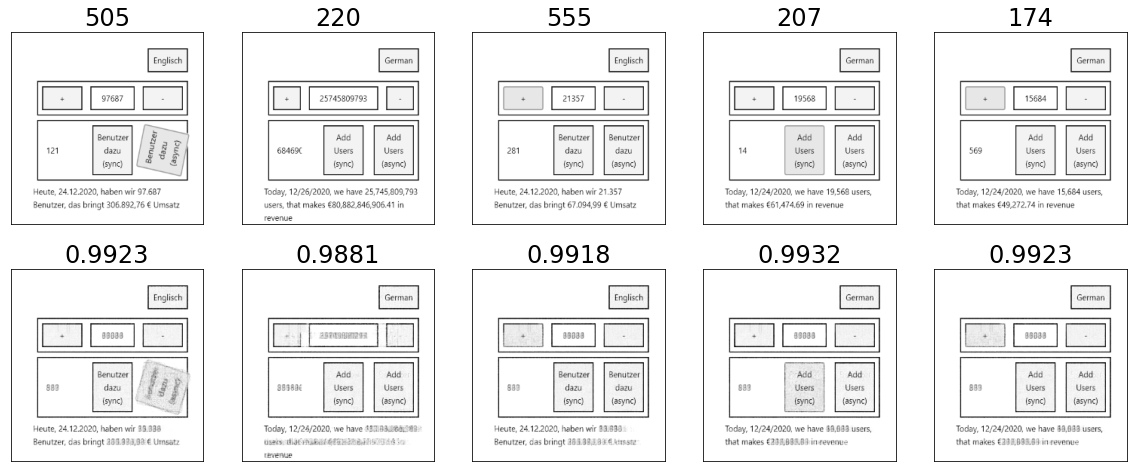

In [40]:
compare_samples(train, train_pred)

In [41]:
scores = []
for true_image, predicted_image in zip(train, train_pred):
  score = rounded_accuracy_for_single_image(true_image, predicted_image)
  scores.append(score)
train_scores = np.array(scores)  
train_scores.shape

(603,)

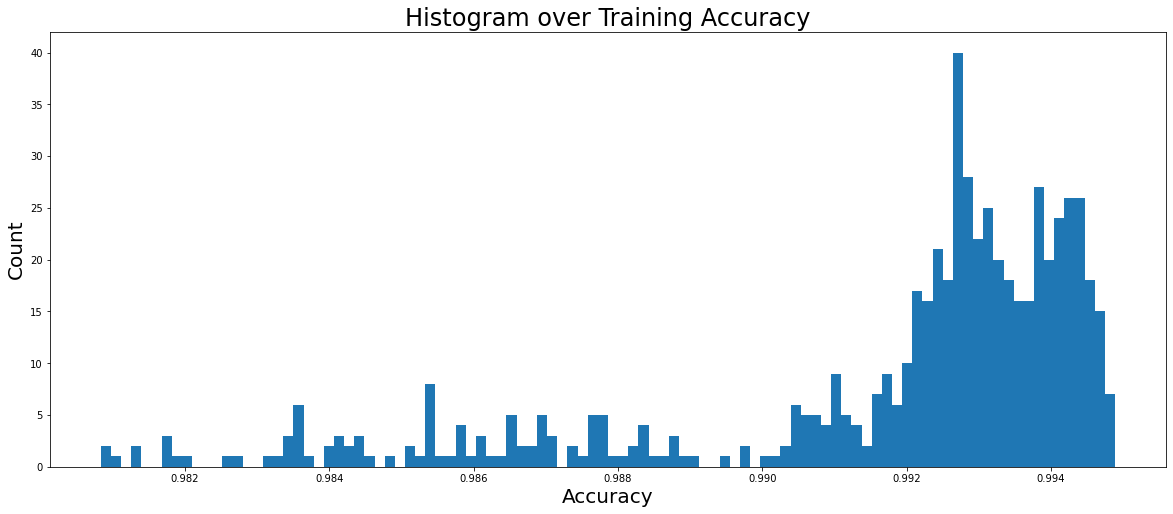

In [42]:
plt.title('Histogram over Training Accuracy')
plt.ylabel("Count")
plt.xlabel("Accuracy")

plt.hist(train_scores, bins=100);

## Comparing samples from Regression Test Set

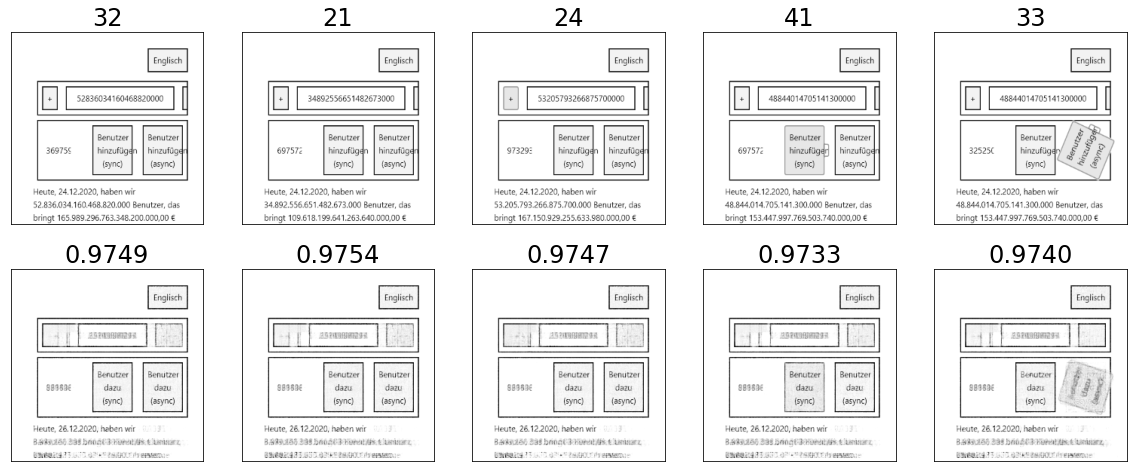

In [43]:
compare_samples(test, test_pred)

In [44]:
scores = []
for true_image, predicted_image in zip(test, test_pred):
  score = rounded_accuracy_for_single_image(true_image, predicted_image)
  scores.append(score)
test_scores = np.array(scores)  
test_scores.shape

(51,)

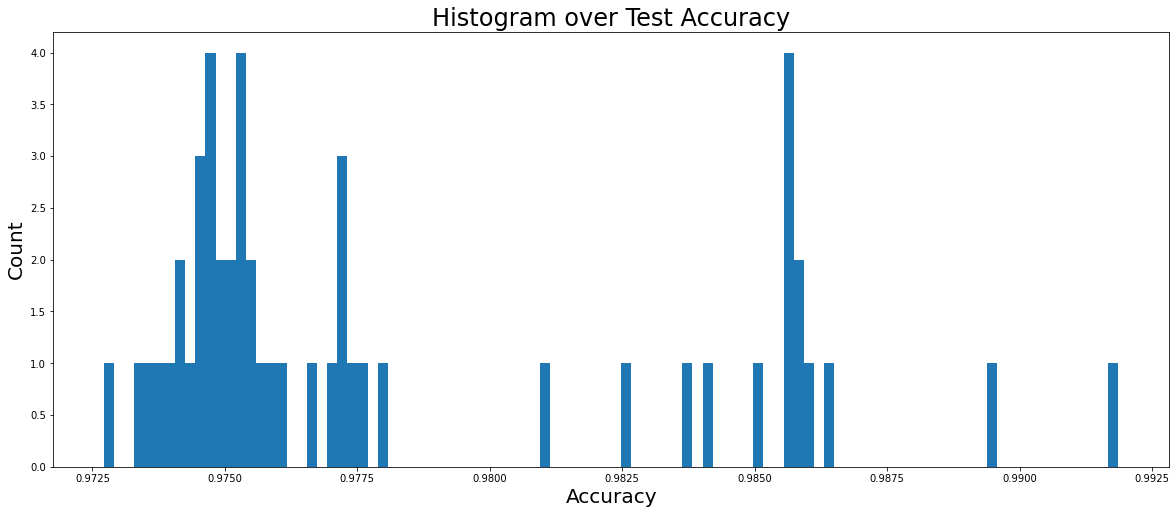

In [45]:
plt.title('Histogram over Test Accuracy')
plt.ylabel("Count")
plt.xlabel("Accuracy")

plt.hist(test_scores, bins=100);

# Step 4: Identify suspicious screenshots from test set

Suspicious Screenshots: 41 von 51


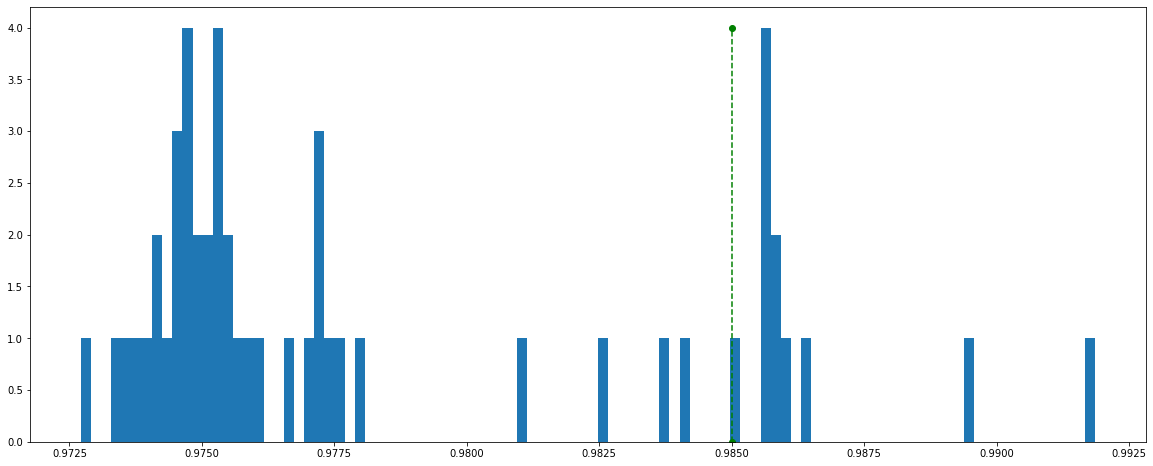

In [46]:
#@title Threshold: below which matching score do we consider a screenshot suspicious? 

threshold = 0.985 #@param {type:"slider", min:0.95, max:1.0, step:0.0001}
test_mask = test_scores < threshold
n, _, _ = plt.hist(test_scores, bins=100)
plt.plot((threshold, threshold), (0, n.max()),  color='green', marker='o', linestyle='dashed');
print("Suspicious Screenshots: {:d} von {:d}".format(np.count_nonzero(test_mask), test_mask.shape[0]));

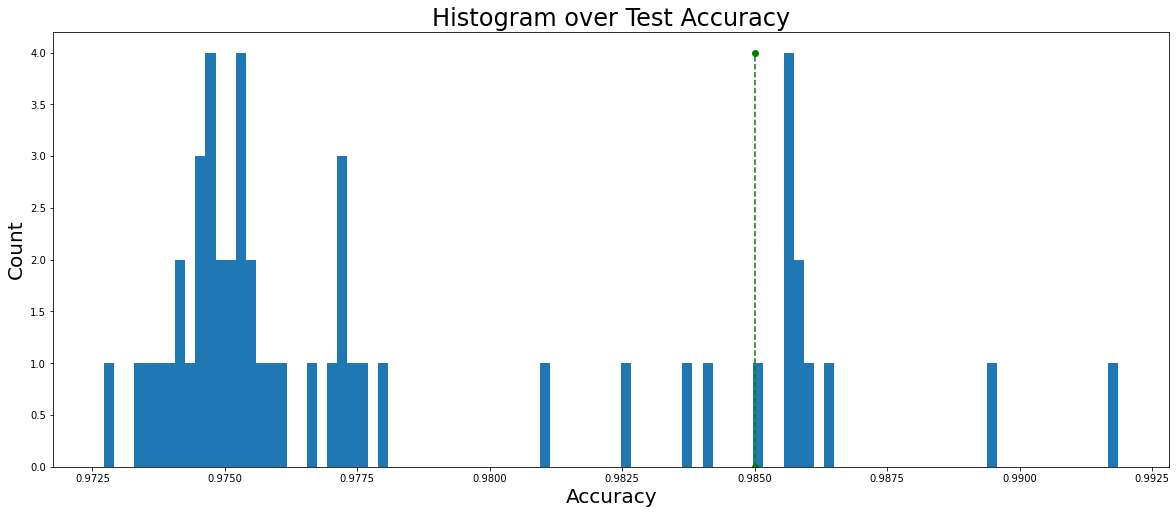

In [47]:
plt.title('Histogram over Test Accuracy')
plt.ylabel("Count")
plt.xlabel("Accuracy")

n, _, _ = plt.hist(test_scores, bins=100)
plt.plot((threshold, threshold), (0, n.max()),  color='green', marker='o', linestyle='dashed');

## Predicted as correct

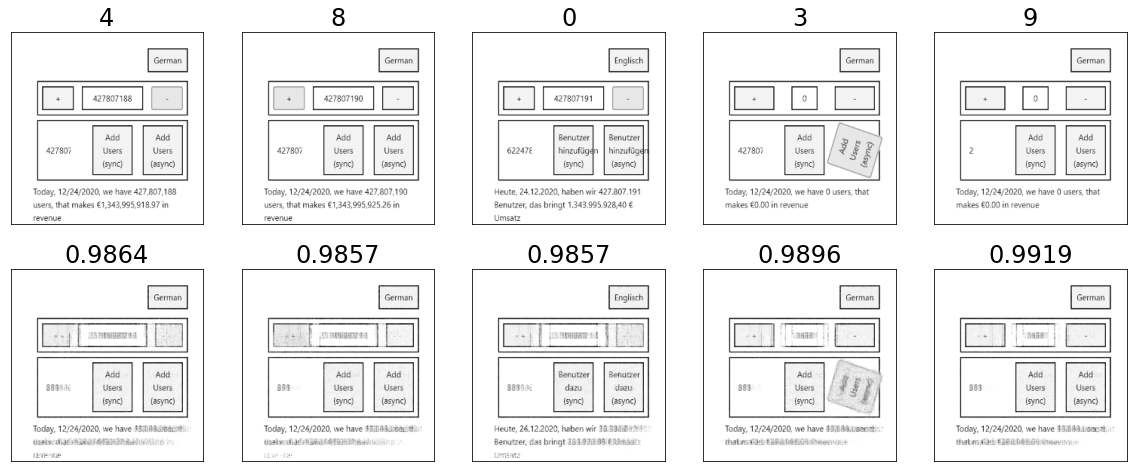

In [48]:
compare_samples(test[~test_mask], test_pred[~test_mask])

## Predicted as broken

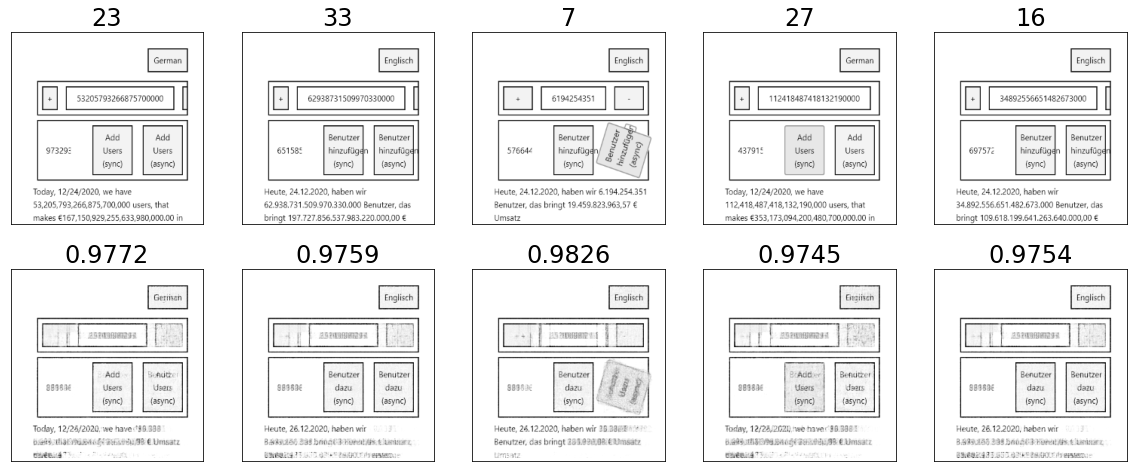

In [49]:
compare_samples(test[test_mask], test_pred[test_mask])

# Advanced Crazyness I: Checking the numbers of zeros and overall average to check effect of L1 and L2 regularization

In [50]:
test_embedded_imgs = conv_encoder.predict(test)
test_embedded_imgs.shape

(51, 8)

In [51]:
test_embedded_imgs[0]

array([  22.89241 ,  -62.960995,  -10.278331,   50.621834,  -72.94024 ,
         -6.82811 ,  -18.628674, -147.23993 ], dtype=float32)

In [52]:
test_embedded_imgs[25]

array([  13.0214615,  -26.78431  ,    5.6303873,   -0.728435 ,
        -97.03033  ,   78.766945 ,  -10.673405 , -139.07155  ],
      dtype=float32)

In [53]:
test_embedded_imgs[50]

array([  26.051601 ,    2.4032352,  -13.475602 ,   -8.744414 ,
       -121.93392  ,   56.435894 ,   10.677388 , -147.23566  ],
      dtype=float32)

In [54]:
test_embedded_imgs[7]

array([  49.531452 ,  -76.579056 ,  -13.040381 ,   18.256912 ,
        -89.0313   ,   46.161945 ,   -1.5051415, -106.17251  ],
      dtype=float32)

In [55]:
test_embedded_imgs[43]

array([  46.106274,  -75.28717 ,  -11.986696,   15.93705 ,  -90.04174 ,
         46.20134 ,   -3.960972, -105.67245 ], dtype=float32)

In [56]:
tf.reduce_mean(test_embedded_imgs).numpy(), tf.reduce_mean(encoding_dim - tf.math.count_nonzero(test_embedded_imgs, axis=1)).numpy()

(-24.66854, 0)

# Advanced Crazyness II: Inspecting images directly before going into hidden representation

In [57]:
collection_layer = conv_encoder.get_layer("collection_image")
model_stub = Model(inputs = conv_encoder.input, outputs = collection_layer.output)
test_collection_imgs = model_stub.predict(test)
test_collection_imgs.shape

(51, 8, 8, 1)

In [58]:
test_collection_imgs = tf.reshape(test_collection_imgs, (test_collection_imgs.shape[0], test_collection_imgs.shape[1], test_collection_imgs.shape[2]))
test_collection_imgs.shape

TensorShape([51, 8, 8])

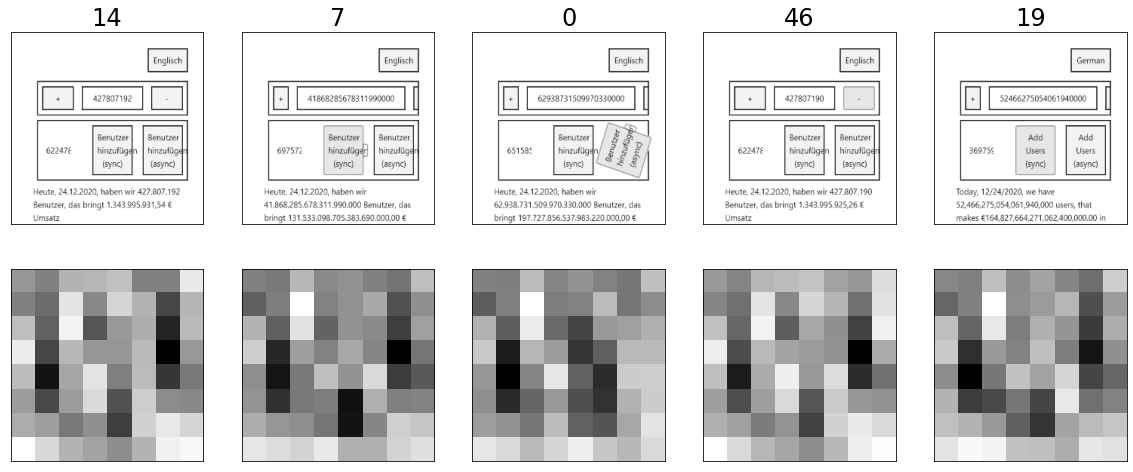

In [59]:
compare_samples(test, test_collection_imgs, n_samples=5, display_accuracy=False)

## Looking at our embeddings

need to reduce to 2 dim to make them plotable

In [60]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# https://umap-learn.readthedocs.io/en/latest/parameters.html
# https://umap-learn.readthedocs.io/en/latest/how_umap_works.html
# https://pair-code.github.io/understanding-umap/

!pip install umap-learn

In [61]:
import umap

In [62]:
%%time

if encoding_dim == 2:
  test_embedded_imgs = test_embedded_imgs
else:
  print('reducing dim using umap')
  # default
  reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
  # local structure (n_neighbors), a bit more stretched out (min_dist)
  # reducer = umap.UMAP(random_state=42, n_neighbors=5, min_dist=.99)
  test_embedded_imgs = reducer.fit_transform(test_embedded_imgs)

reducing dim using umap
CPU times: user 5.85 s, sys: 0 ns, total: 5.85 s
Wall time: 5.82 s


In [63]:
test_embedded_imgs.shape

(51, 2)

In [64]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
test_embedded_imgs = scaler.fit_transform(test_embedded_imgs)
test_embedded_imgs.shape

(51, 2)

In [65]:
# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

from PIL import Image

def plot_embeddings(embeddings_2d, images, min_dist = 0.2, zoom=0.1, plot_samples=True):
  plt.figure(figsize=(50, 50))
  cmap = plt.cm.tab10
  if plot_samples:
    image_positions = np.array([[1., 1.]])
    for index, position in enumerate(embeddings_2d):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > min_dist: # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            image = Image.fromarray(images[index])
            # image.putalpha(16)
            imagebox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(image, cmap="gray", zoom=zoom ),
                position, 
                # bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2}
                )
            plt.gca().add_artist(imagebox)
  # plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100)
  plt.axis("off");

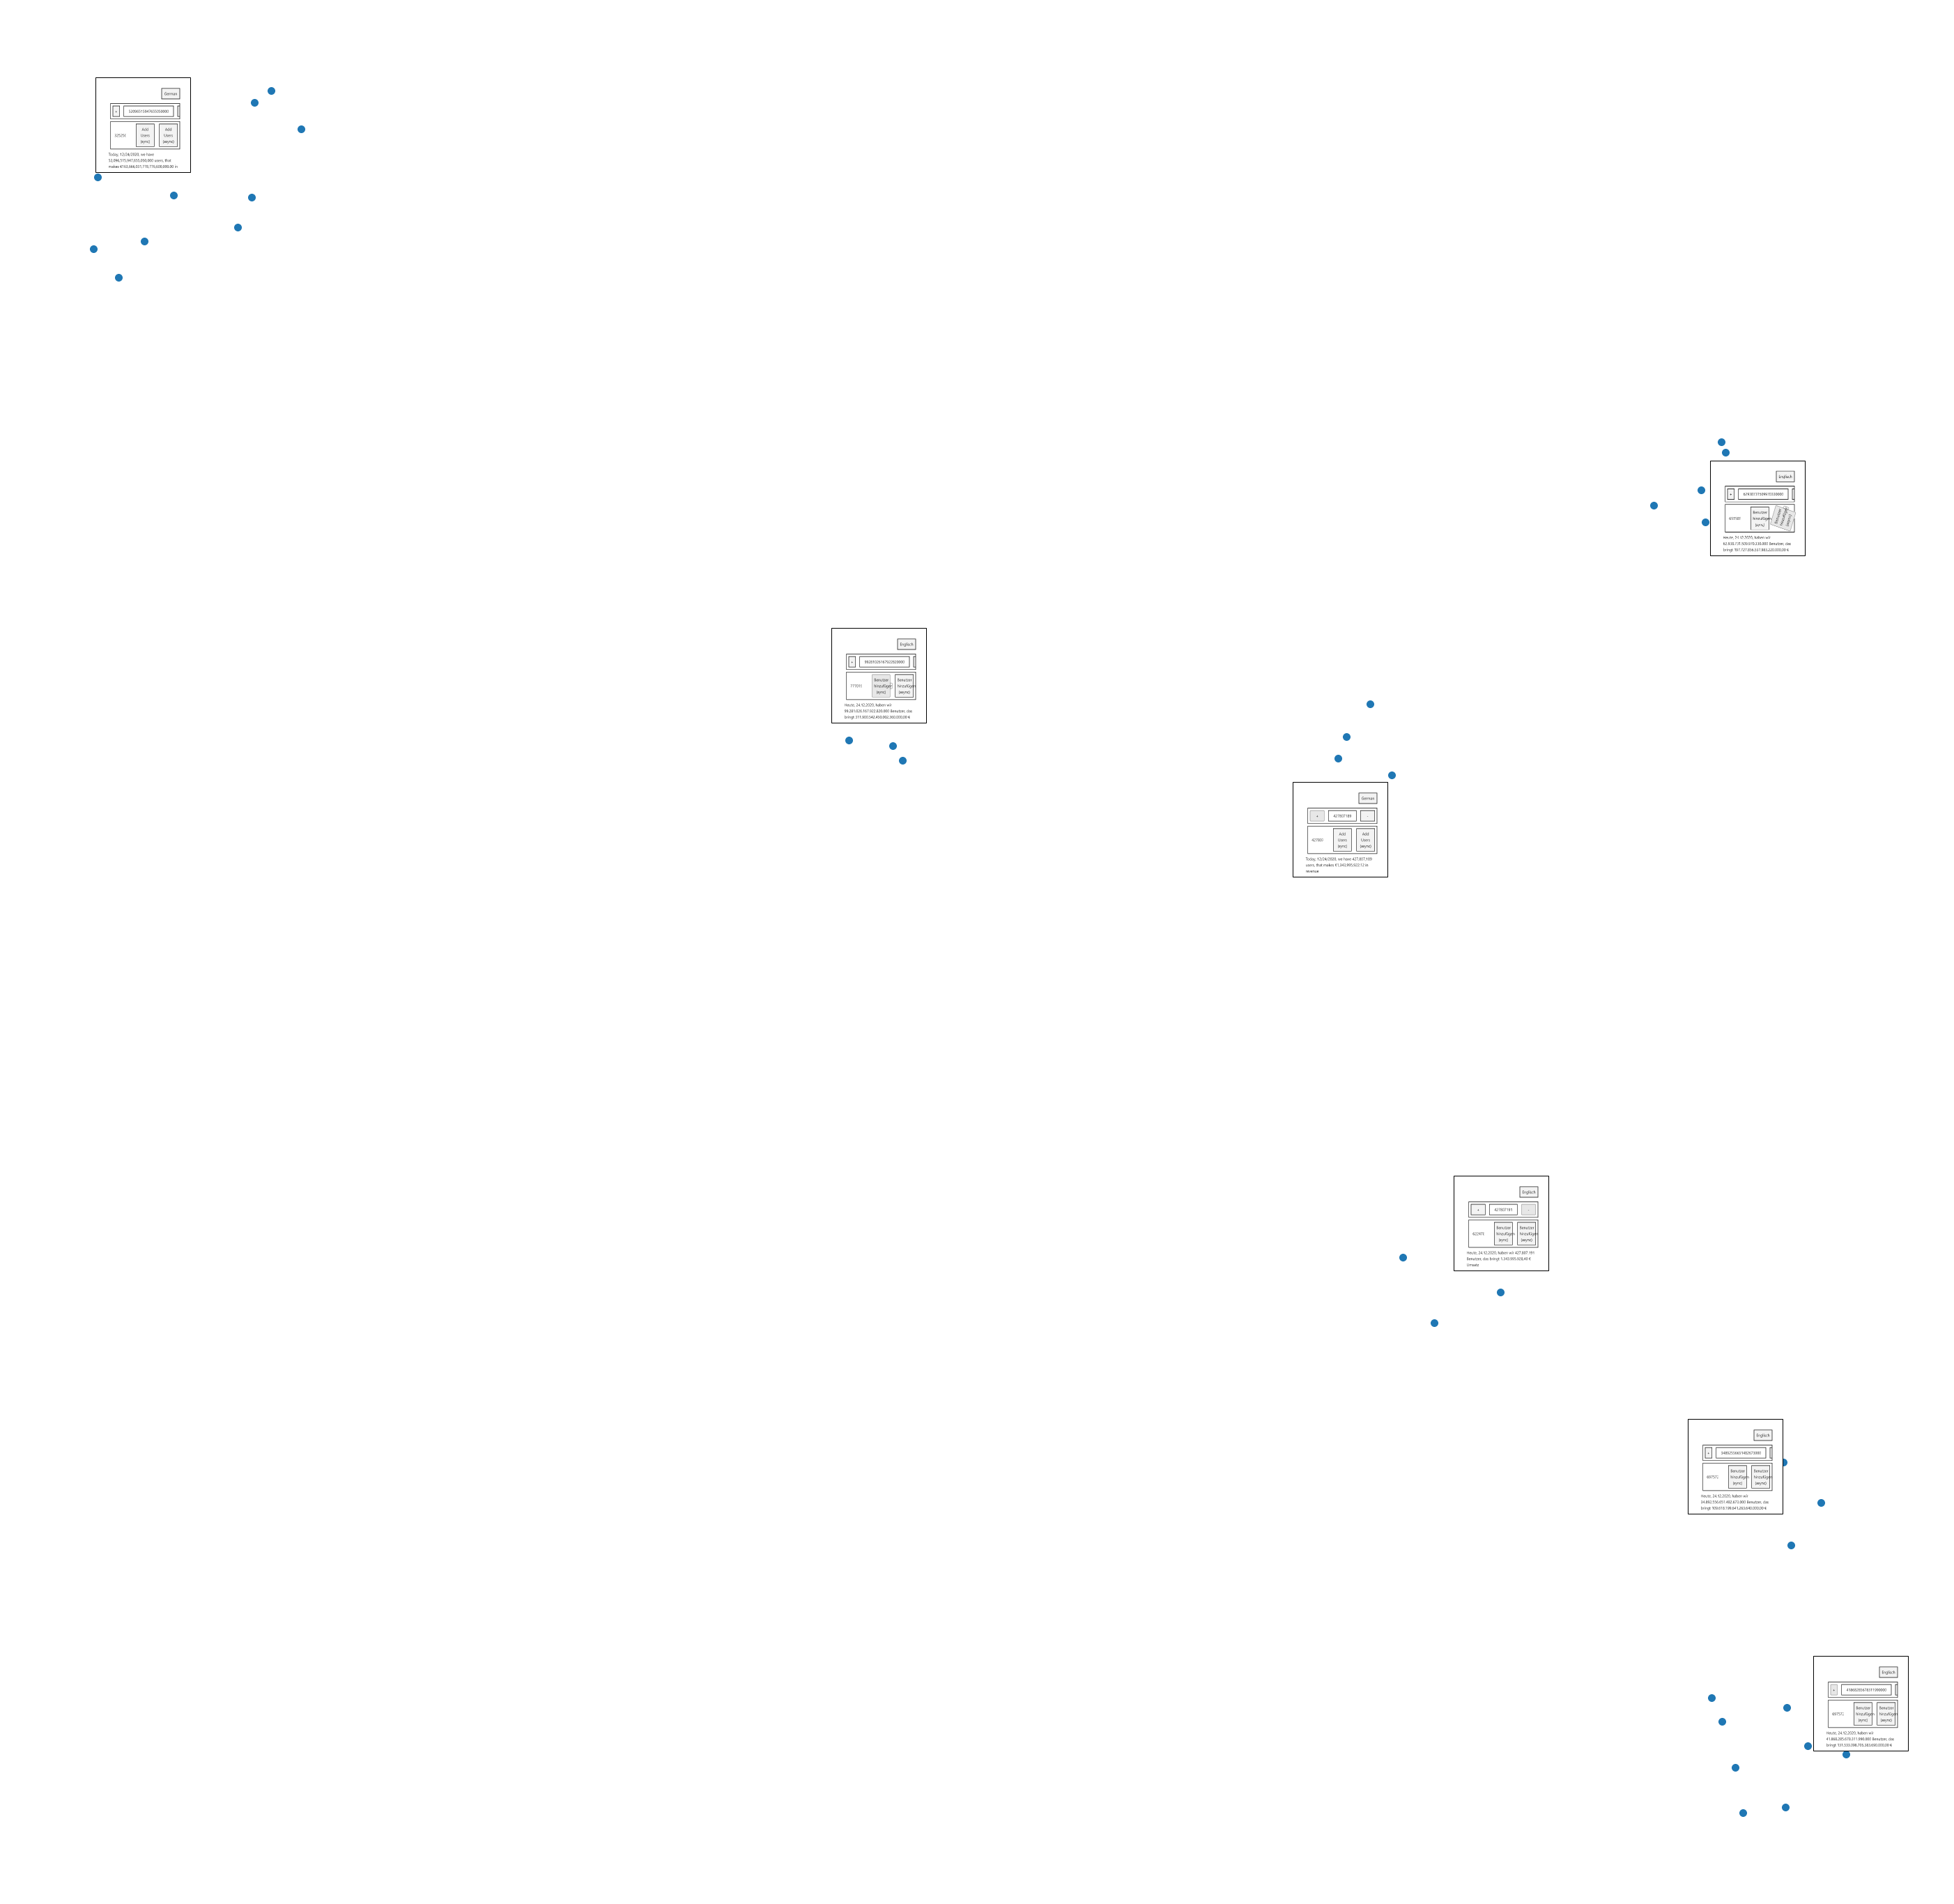

In [66]:
# how far need to labels be from each other in order not to clutter everthing
# might need a bit of adjustment 
min_dist = 0.1

# plot_embeddings(test_embedded_imgs, test, min_dist=min_dist, zoom=0.5, plot_samples=False)
plot_embeddings(test_embedded_imgs, test, min_dist=min_dist, zoom=0.5)

## Same for training data

reducing dim using umap


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


CPU times: user 2.57 s, sys: 117 ms, total: 2.69 s
Wall time: 2.54 s


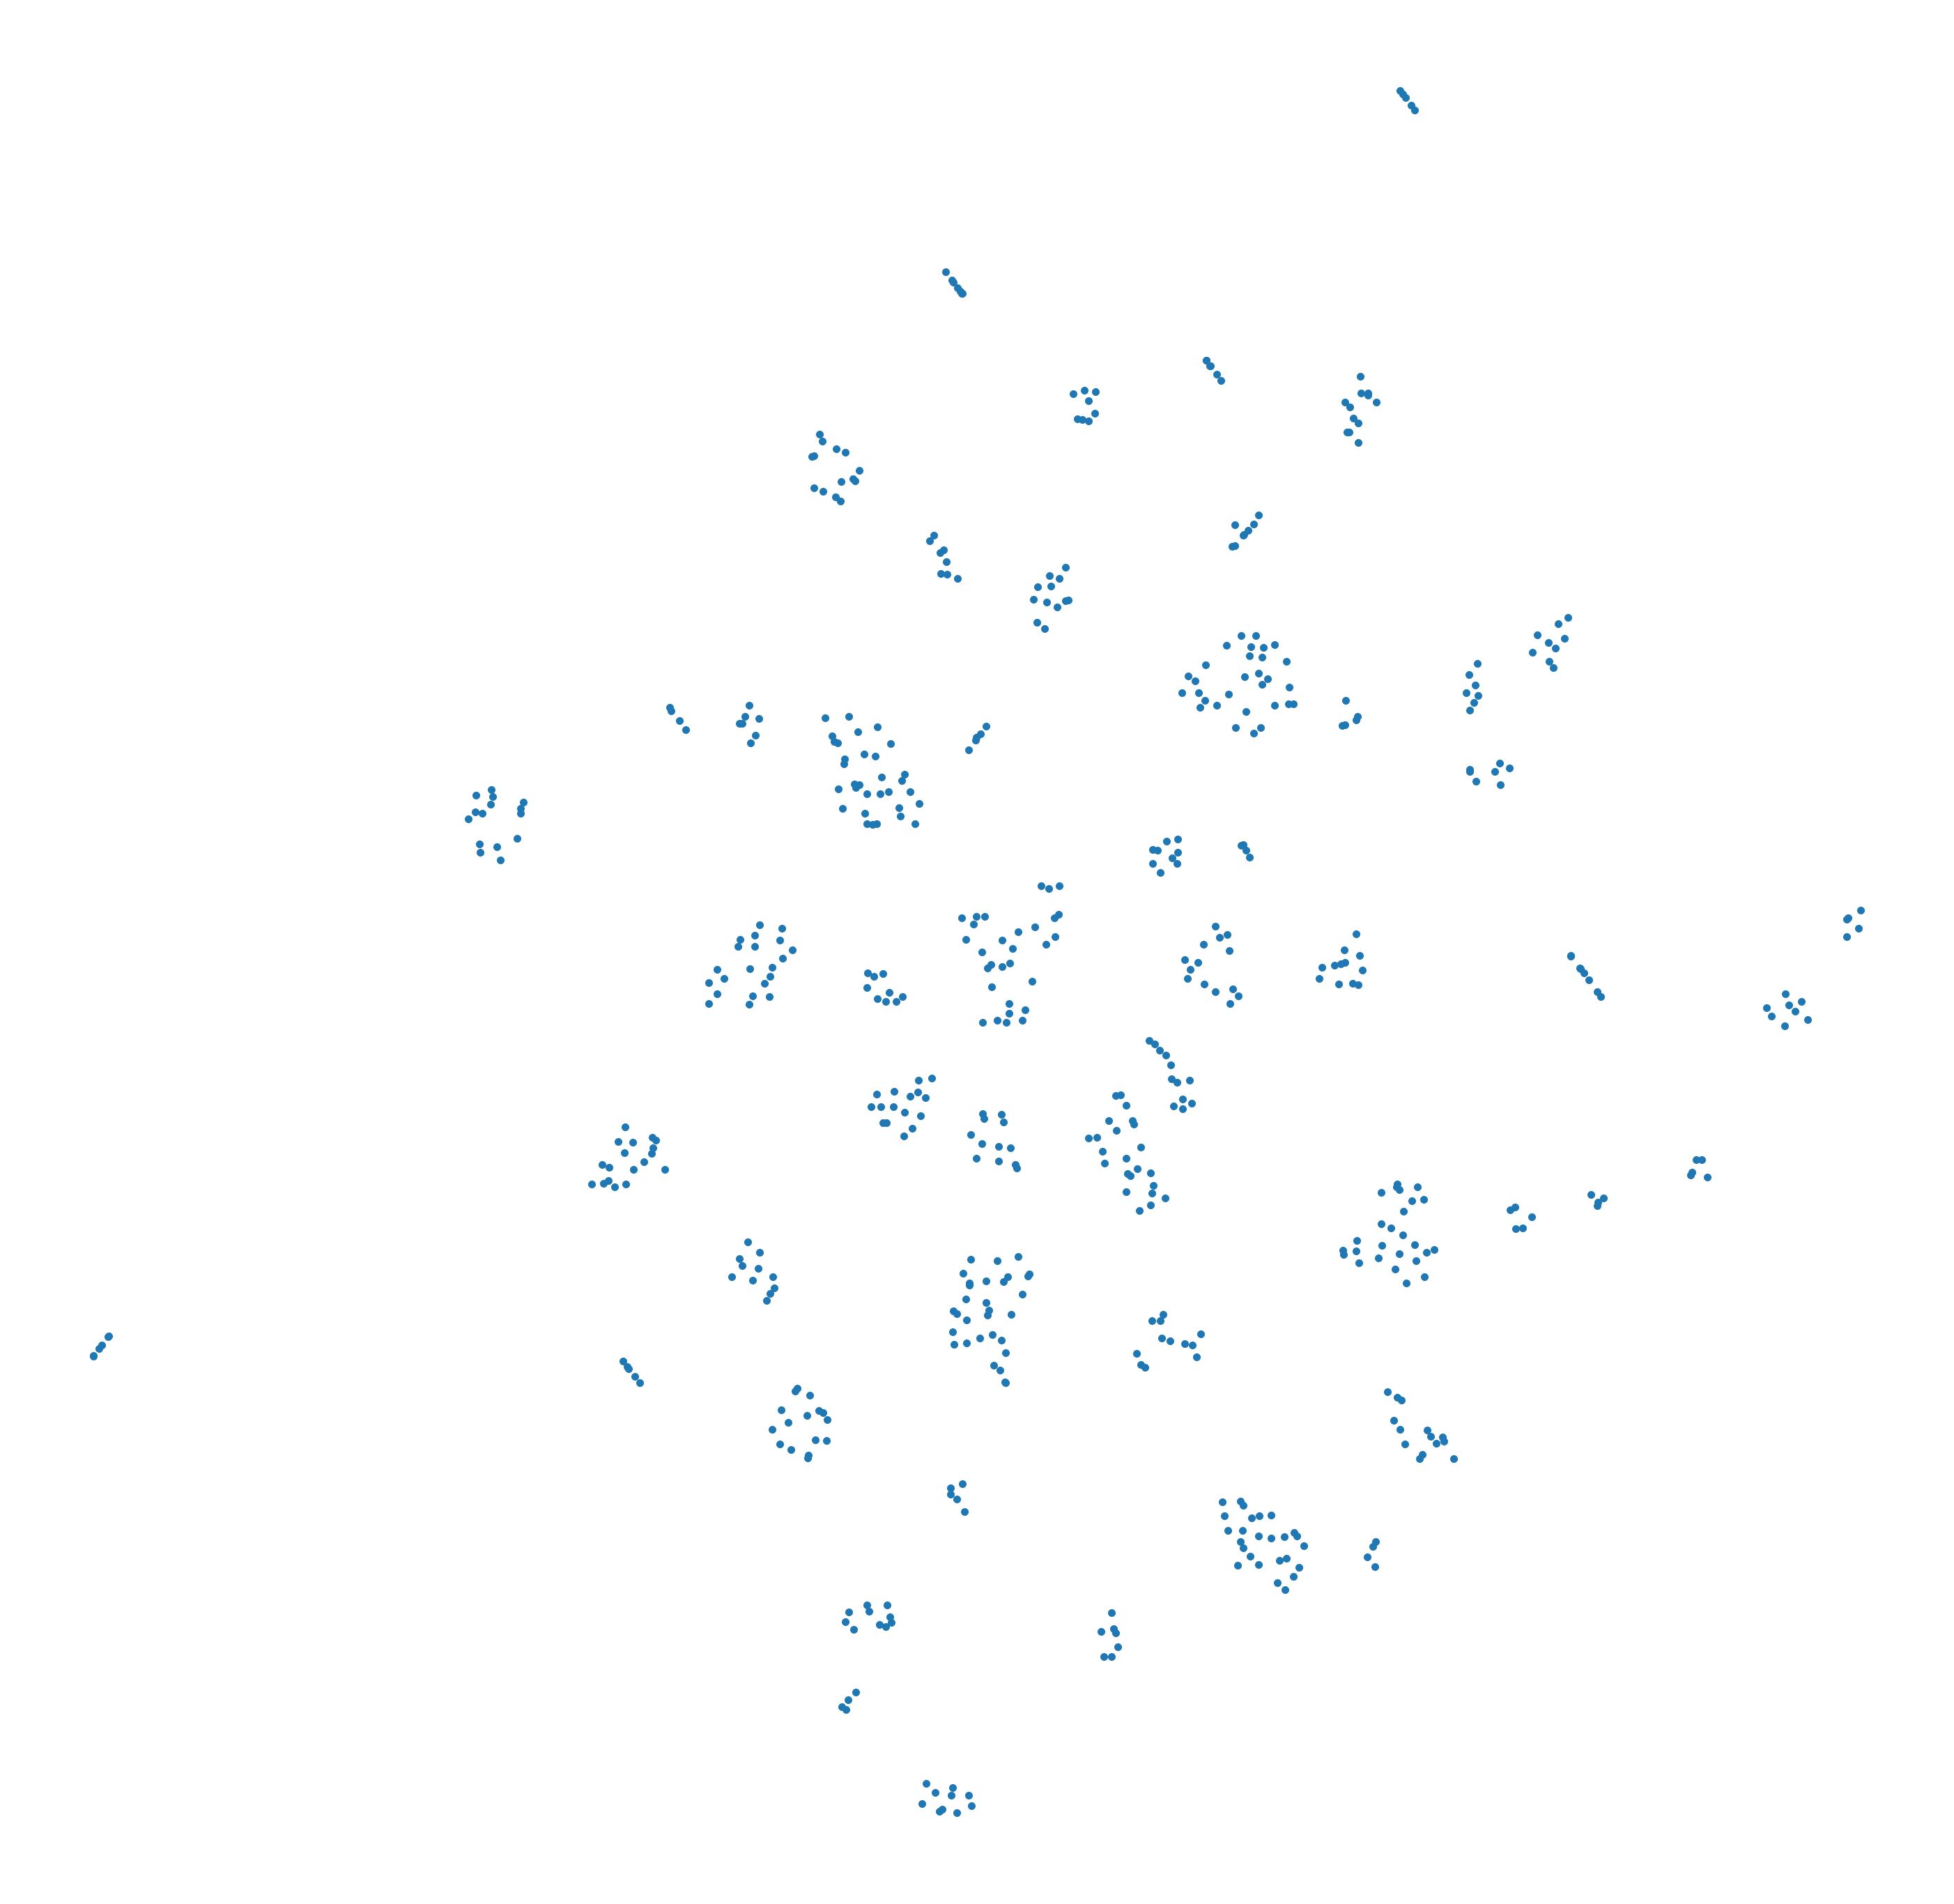

In [67]:
%%time

train_embedded_imgs = conv_encoder.predict(train)

if encoding_dim == 2:
  train_embedded_imgs = train_embedded_imgs
else:
  print('reducing dim using umap')
  # default
  # reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
  # local structure (n_neighbors), a bit more stretched out (min_dist)
  reducer = umap.UMAP(random_state=42, n_neighbors=5, min_dist=.99)
  train_embedded_imgs = reducer.fit_transform(train_embedded_imgs)

train_embedded_imgs = scaler.fit_transform(train_embedded_imgs)

min_dist = 0.1

plot_embeddings(train_embedded_imgs, train, min_dist=min_dist, zoom=0.5, plot_samples=False)

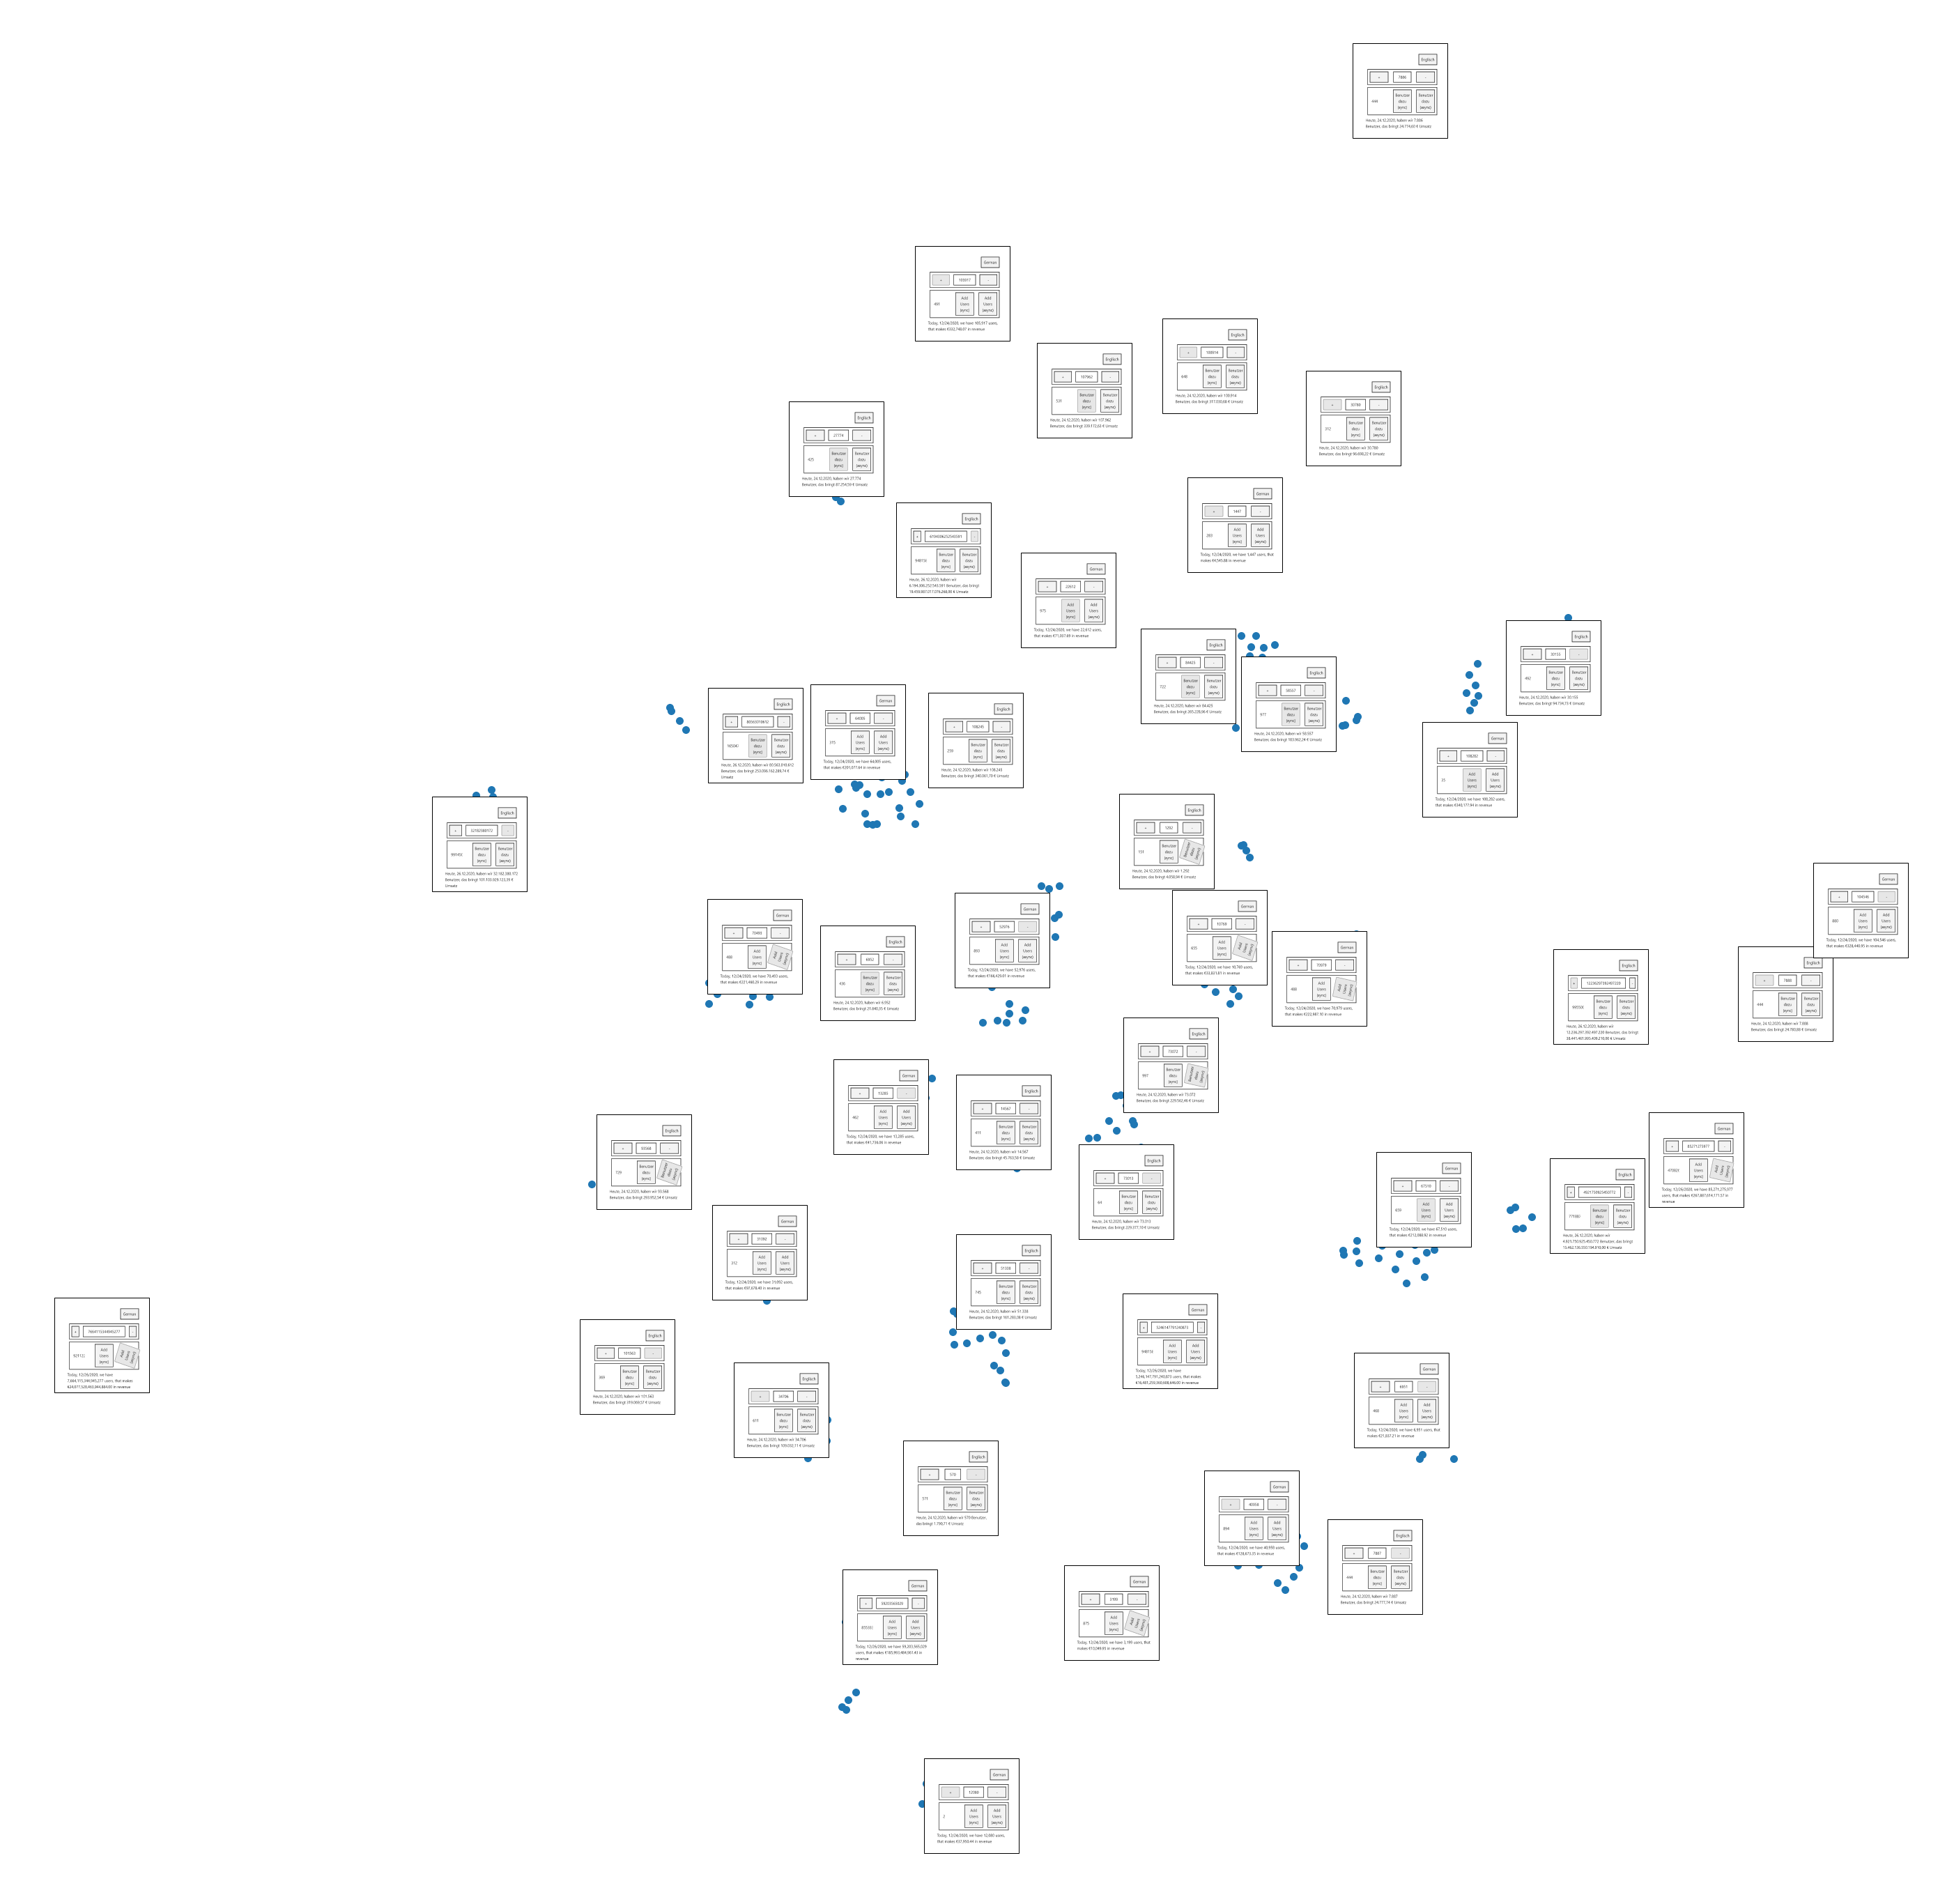

In [68]:
plot_embeddings(train_embedded_imgs, train, min_dist=min_dist, zoom=0.5, plot_samples=True)